<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/test-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 12.2 MB/s eta 0:00:00


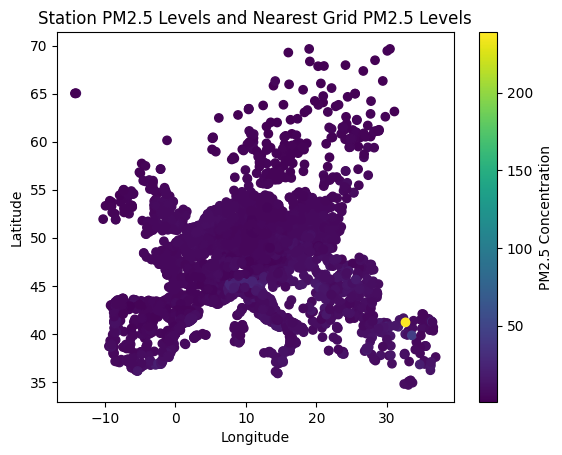

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 150.70328181840165
Full Sill: 150.70328181890395
Range: 51.57270687166678
Nugget: 5.022939331979603e-10 



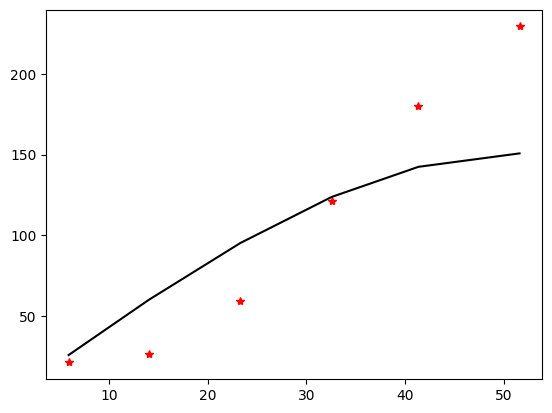

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



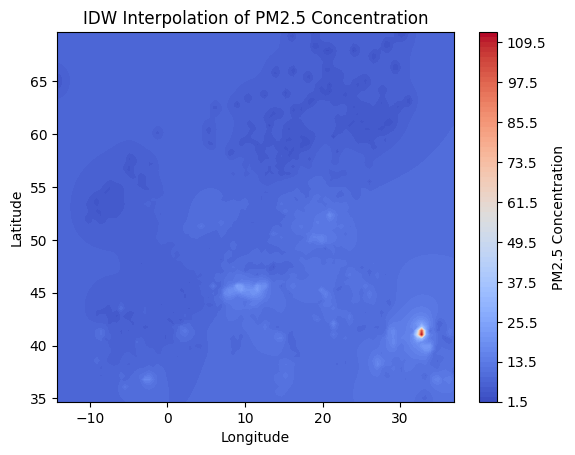

In [4]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

# Φόρτωση του αρχείου CSV
data = pd.read_csv('basePM25nearest_grid.csv')

# Εξαγωγή των δεδομένων (με αντιγραφή για αποφυγή SettingWithCopyWarning)
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()

grid_data = data[['nearest_grid_lon', 'nearest_grid_lat', 'nearest_SURF_ug_PM25_rh50']].copy()

grid_coords = grid_data[['nearest_grid_lon', 'nearest_grid_lat']].values
grid_tree = cKDTree(grid_coords)

station_coords = stations_data[['lon', 'lat']].values

distances, indices = grid_tree.query(station_coords, k=1)

# Αντιστοίχιση των τιμών ρύπανσης στους σταθμούς από τα κοντινότερα πλέγματα
stations_data.loc[:, 'nearest_SURF_ug_PM25_rh50'] = grid_data.iloc[indices.flatten()]['nearest_SURF_ug_PM25_rh50'].values

# Οπτικοποίηση των αποτελεσμάτων
plt.scatter(stations_data['lon'], stations_data['lat'], c=stations_data['nearest_SURF_ug_PM25_rh50'], cmap='viridis')
plt.colorbar(label='PM2.5 Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station PM2.5 Levels and Nearest Grid PM2.5 Levels')
plt.show()

# 1. Εφαρμογή Kriging (Ordinary Kriging)
OK = OrdinaryKriging(
    stations_data['lon'].values,
    stations_data['lat'].values,
    stations_data['SURF_ug_PM25_rh50'].values,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True
)

gridx = np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 100)
gridy = np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 100)

z, ss = OK.execute('grid', gridx, gridy)

# 2. Εφαρμογή IDW (Inverse Distance Weighting)
def idw(x, y, values, xi, yi, power=2):
    tree = cKDTree(np.c_[x, y])
    distances, indices = tree.query(np.c_[xi, yi], k=len(x))
    weights = 1 / (distances**power)
    return np.sum(weights * values[indices]) / np.sum(weights)

# Δημιουργία πλέγματος για την εφαρμογή IDW
grid_x, grid_y = np.meshgrid(
    np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 100),
    np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 100)
)

idw_values = np.array([
    idw(stations_data['lon'].values, stations_data['lat'].values, stations_data['SURF_ug_PM25_rh50'].values, xi, yi)
    for xi, yi in zip(grid_x.flatten(), grid_y.flatten())
])
idw_values = idw_values.reshape(grid_x.shape)

# Οπτικοποίηση των αποτελεσμάτων IDW
plt.contourf(grid_x, grid_y, idw_values, 100, cmap='coolwarm')
plt.colorbar(label='PM2.5 Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('IDW Interpolation of PM2.5 Concentration')
plt.show()


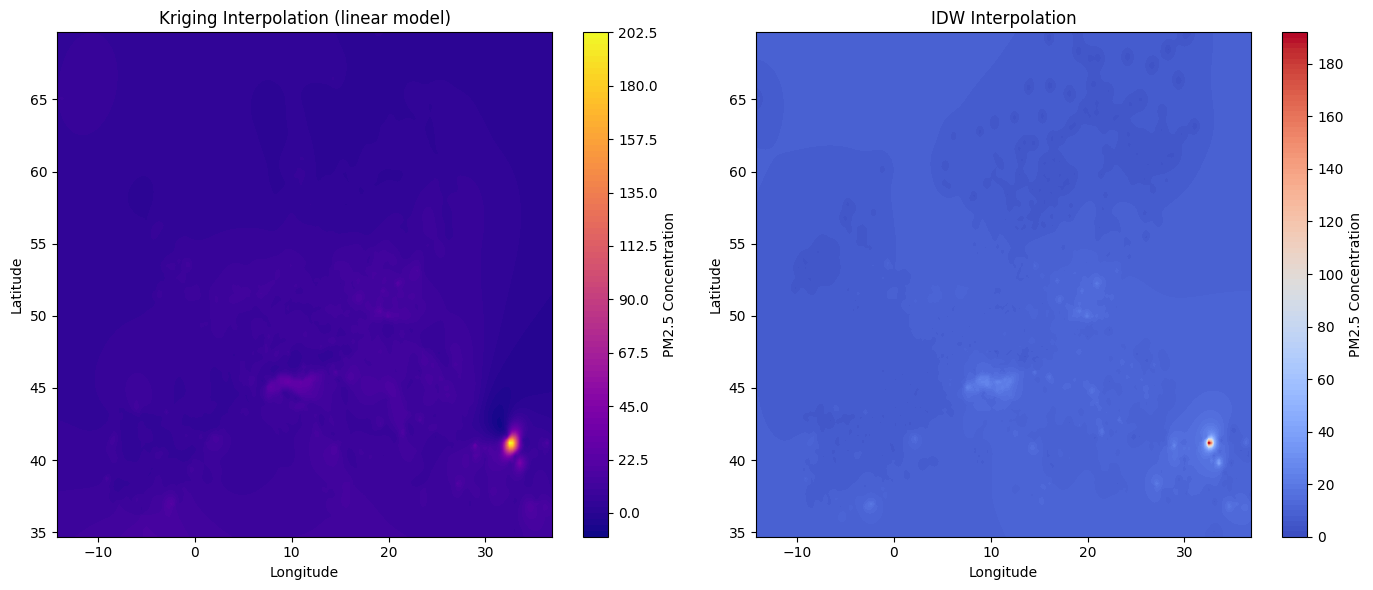

In [8]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

# --- Φόρτωση και προεπεξεργασία δεδομένων ---
data = pd.read_csv('basePM25nearest_grid.csv')

# Αφαίρεση NaN τιμών για αποφυγή σφαλμάτων
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].dropna().copy()
grid_data = data[['nearest_grid_lon', 'nearest_grid_lat', 'nearest_SURF_ug_PM25_rh50']].dropna().copy()

# Δημιουργία KDTree για γρήγορη εύρεση γειτόνων
grid_coords = grid_data[['nearest_grid_lon', 'nearest_grid_lat']].values
grid_tree = cKDTree(grid_coords)
station_coords = stations_data[['lon', 'lat']].values

distances, indices = grid_tree.query(station_coords, k=1)

# Αντιστοίχιση τιμών ρύπανσης στους σταθμούς
stations_data.loc[:, 'nearest_SURF_ug_PM25_rh50'] = grid_data.iloc[indices.flatten()]['nearest_SURF_ug_PM25_rh50'].values

# --- Επιλογή βέλτιστου μοντέλου Kriging ---
def best_kriging_model(lon, lat, values):
    models = ['spherical', 'linear', 'exponential', 'gaussian']
    best_model = 'spherical'
    best_score = float('inf')

    for model in models:
        try:
            OK = OrdinaryKriging(lon, lat, values, variogram_model=model, verbose=False, enable_plotting=False)
            _, error = OK.execute('grid', np.linspace(lon.min(), lon.max(), 10), np.linspace(lat.min(), lat.max(), 10))
            score = np.mean(error)
            if score < best_score:
                best_score = score
                best_model = model
        except:
            continue

    return best_model

best_model = best_kriging_model(stations_data['lon'].values, stations_data['lat'].values, stations_data['SURF_ug_PM25_rh50'].values)

# --- Kriging Interpolation ---
OK = OrdinaryKriging(
    stations_data['lon'].values,
    stations_data['lat'].values,
    stations_data['SURF_ug_PM25_rh50'].values,
    variogram_model=best_model,
    verbose=False,
    enable_plotting=False
)

gridx = np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 200)
gridy = np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 200)

z, ss = OK.execute('grid', gridx, gridy)

# --- IDW Interpolation χωρίς numba ---
def idw(x, y, values, xi, yi, power=2):
    tree = cKDTree(np.c_[x, y])
    distances, indices = tree.query(np.c_[xi, yi], k=len(x))
    weights = 1 / (distances ** power)
    return np.sum(weights * values[indices]) / np.sum(weights)

grid_x, grid_y = np.meshgrid(
    np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 200),
    np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 200)
)

idw_values = np.array([
    idw(stations_data['lon'].values, stations_data['lat'].values, stations_data['SURF_ug_PM25_rh50'].values, xi, yi)
    for xi, yi in zip(grid_x.flatten(), grid_y.flatten())
]).reshape(grid_x.shape)

# --- Οπτικοποίηση ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Kriging Plot
c1 = ax[0].contourf(gridx, gridy, z, 100, cmap='plasma')
plt.colorbar(c1, ax=ax[0], label='PM2.5 Concentration')
ax[0].set_title(f'Kriging Interpolation ({best_model} model)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# IDW Plot
c2 = ax[1].contourf(grid_x, grid_y, idw_values, 100, cmap='coolwarm')
plt.colorbar(c2, ax=ax[1], label='PM2.5 Concentration')
ax[1].set_title('IDW Interpolation')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


<ipython-input-10-e11bddd4dbd0>:82: UserWarning: Log scale: values of z <= 0 have been masked
  c1 = ax[0].contourf(gridx, gridy, z, 100, cmap='plasma', norm=LogNorm(vmin=1, vmax=1000))


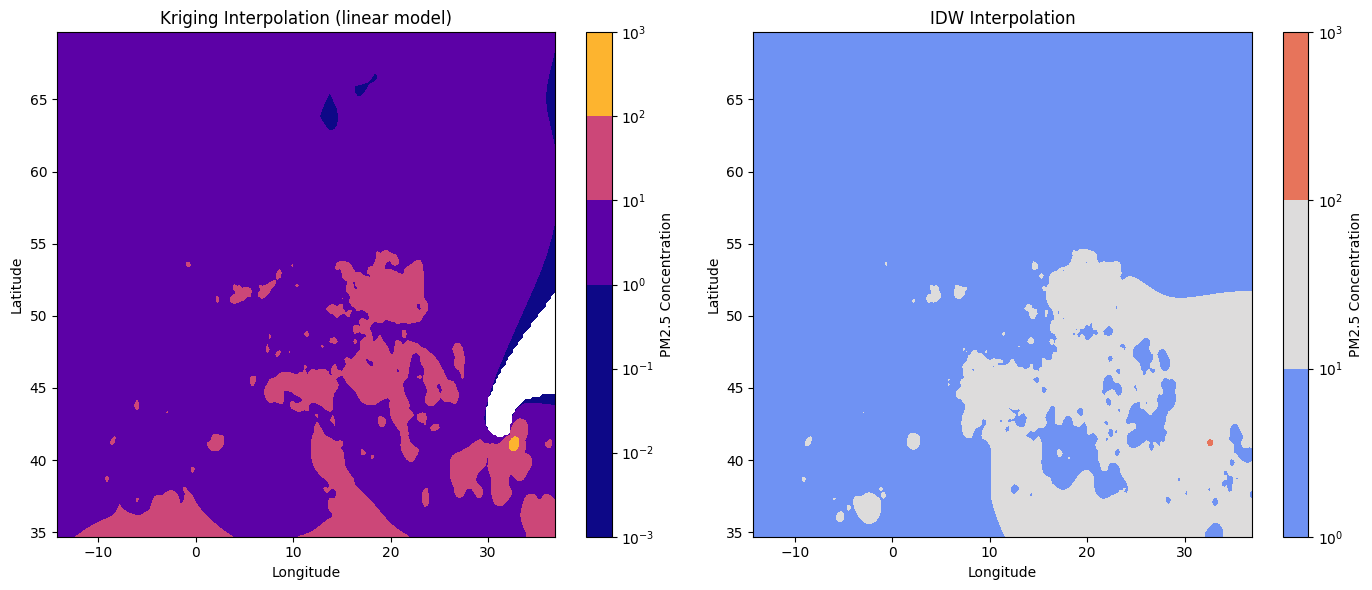

In [10]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --- Φόρτωση και προεπεξεργασία δεδομένων ---
data = pd.read_csv('basePM25nearest_grid.csv')

# Αφαίρεση NaN τιμών για αποφυγή σφαλμάτων
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].dropna().copy()
grid_data = data[['nearest_grid_lon', 'nearest_grid_lat', 'nearest_SURF_ug_PM25_rh50']].dropna().copy()

# Δημιουργία KDTree για γρήγορη εύρεση γειτόνων
grid_coords = grid_data[['nearest_grid_lon', 'nearest_grid_lat']].values
grid_tree = cKDTree(grid_coords)
station_coords = stations_data[['lon', 'lat']].values

distances, indices = grid_tree.query(station_coords, k=1)

# Αντιστοίχιση τιμών ρύπανσης στους σταθμούς
stations_data.loc[:, 'nearest_SURF_ug_PM25_rh50'] = grid_data.iloc[indices.flatten()]['nearest_SURF_ug_PM25_rh50'].values

# --- Επιλογή βέλτιστου μοντέλου Kriging ---
def best_kriging_model(lon, lat, values):
    models = ['spherical', 'linear', 'exponential', 'gaussian']
    best_model = 'spherical'
    best_score = float('inf')

    for model in models:
        try:
            OK = OrdinaryKriging(lon, lat, values, variogram_model=model, verbose=False, enable_plotting=False)
            _, error = OK.execute('grid', np.linspace(lon.min(), lon.max(), 10), np.linspace(lat.min(), lat.max(), 10))
            score = np.mean(error)
            if score < best_score:
                best_score = score
                best_model = model
        except:
            continue

    return best_model

best_model = best_kriging_model(stations_data['lon'].values, stations_data['lat'].values, stations_data['SURF_ug_PM25_rh50'].values)

# --- Kriging Interpolation ---
OK = OrdinaryKriging(
    stations_data['lon'].values,
    stations_data['lat'].values,
    stations_data['SURF_ug_PM25_rh50'].values,
    variogram_model=best_model,
    verbose=False,
    enable_plotting=False
)

gridx = np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 200)
gridy = np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 200)

z, ss = OK.execute('grid', gridx, gridy)

# --- IDW Interpolation χωρίς numba ---
def idw(x, y, values, xi, yi, power=2):
    tree = cKDTree(np.c_[x, y])
    distances, indices = tree.query(np.c_[xi, yi], k=len(x))
    weights = 1 / (distances ** power)
    return np.sum(weights * values[indices]) / np.sum(weights)

grid_x, grid_y = np.meshgrid(
    np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 200),
    np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 200)
)

idw_values = np.array([
    idw(stations_data['lon'].values, stations_data['lat'].values, stations_data['SURF_ug_PM25_rh50'].values, xi, yi)
    for xi, yi in zip(grid_x.flatten(), grid_y.flatten())
]).reshape(grid_x.shape)

# --- Οπτικοποίηση ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Kriging Plot
c1 = ax[0].contourf(gridx, gridy, z, 100, cmap='plasma', norm=LogNorm(vmin=1, vmax=1000))
plt.colorbar(c1, ax=ax[0], label='PM2.5 Concentration')
ax[0].set_title(f'Kriging Interpolation ({best_model} model)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# IDW Plot
c2 = ax[1].contourf(grid_x, grid_y, idw_values, 100, cmap='coolwarm', norm=LogNorm(vmin=1, vmax=1000))
plt.colorbar(c2, ax=ax[1], label='PM2.5 Concentration')
ax[1].set_title('IDW Interpolation')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


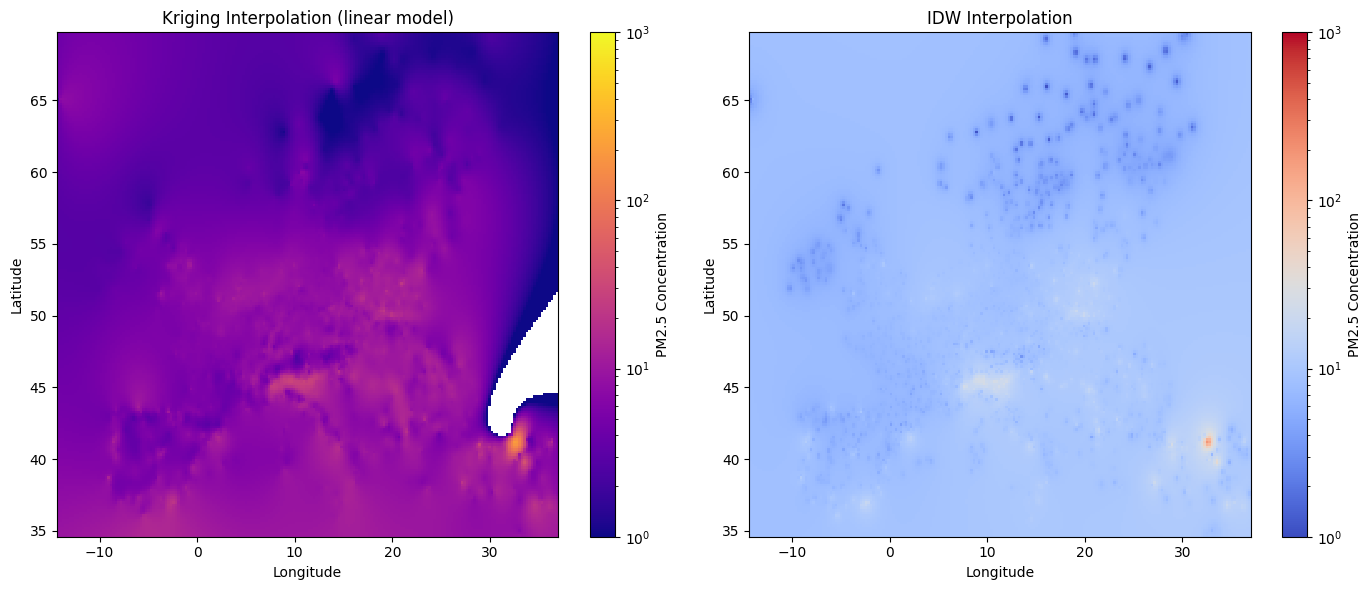

In [23]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Φόρτωση και προεπεξεργασία δεδομένων ---
data = pd.read_csv('basePM25nearest_grid.csv')

# Αφαίρεση NaN τιμών για αποφυγή σφαλμάτων
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].dropna().copy()
grid_data = data[['nearest_grid_lon', 'nearest_grid_lat', 'nearest_SURF_ug_PM25_rh50']].dropna().copy()

# Δημιουργία KDTree για γρήγορη εύρεση γειτόνων
grid_coords = grid_data[['nearest_grid_lon', 'nearest_grid_lat']].values
grid_tree = cKDTree(grid_coords)
station_coords = stations_data[['lon', 'lat']].values

distances, indices = grid_tree.query(station_coords, k=1)

# Αντιστοίχιση τιμών ρύπανσης στους σταθμούς
stations_data.loc[:, 'nearest_SURF_ug_PM25_rh50'] = grid_data.iloc[indices.flatten()]['nearest_SURF_ug_PM25_rh50'].values

# --- Επιλογή βέλτιστου μοντέλου Kriging ---
def best_kriging_model(lon, lat, values):
    models = ['spherical', 'linear', 'exponential', 'gaussian']
    best_model = 'spherical'
    best_score = float('inf')

    for model in models:
        try:
            OK = OrdinaryKriging(lon, lat, values, variogram_model=model, verbose=False, enable_plotting=False)
            _, error = OK.execute('grid', np.linspace(lon.min(), lon.max(), 10), np.linspace(lat.min(), lat.max(), 10))
            score = np.mean(error)
            if score < best_score:
                best_score = score
                best_model = model
        except:
            continue

    return best_model

best_model = best_kriging_model(stations_data['lon'].values, stations_data['lat'].values, stations_data['SURF_ug_PM25_rh50'].values)

# --- Kriging Interpolation ---
OK = OrdinaryKriging(
    stations_data['lon'].values,
    stations_data['lat'].values,
    stations_data['SURF_ug_PM25_rh50'].values,
    variogram_model=best_model,
    verbose=False,
    enable_plotting=False
)

gridx = np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 200)
gridy = np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 200)

z, ss = OK.execute('grid', gridx, gridy)

# --- IDW Interpolation χωρίς numba ---
def idw(x, y, values, xi, yi, power=2):
    tree = cKDTree(np.c_[x, y])
    distances, indices = tree.query(np.c_[xi, yi], k=len(x))
    weights = 1 / (distances ** power)
    return np.sum(weights * values[indices]) / np.sum(weights)

grid_x, grid_y = np.meshgrid(
    np.linspace(stations_data['lon'].min(), stations_data['lon'].max(), 200),
    np.linspace(stations_data['lat'].min(), stations_data['lat'].max(), 200)
)

idw_values = np.array([
    idw(stations_data['lon'].values, stations_data['lat'].values, stations_data['SURF_ug_PM25_rh50'].values, xi, yi)
    for xi, yi in zip(grid_x.flatten(), grid_y.flatten())
]).reshape(grid_x.shape)

# --- Οπτικοποίηση ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Kriging Plot
norm = mcolors.LogNorm(vmin=1, vmax=1000)
c1 = ax[0].pcolormesh(gridx, gridy, z, cmap='plasma', shading='auto', norm=norm)
plt.colorbar(c1, ax=ax[0], label='PM2.5 Concentration')
ax[0].set_title(f'Kriging Interpolation ({best_model} model)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# IDW Plot
c2 = ax[1].pcolormesh(grid_x, grid_y, idw_values, cmap='coolwarm', shading='auto', norm=norm)
plt.colorbar(c2, ax=ax[1], label='PM2.5 Concentration')
ax[1].set_title('IDW Interpolation')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Φόρτωση και προεπεξεργασία δεδομένων ---
# Φόρτωση δεδομένων από το αρχείο NetCDF του μοντέλου
model_data = xr.open_dataset('/content/BaseCase_PERT_PM25_rh50_YEARLY.nc')

# Λήψη των συντεταγμένων του μοντέλου και των τιμών PM2.5
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].values[0]  # Επιλέγουμε τη χρονική στιγμή (το 0 για τον χρόνο)

# Φόρτωση των σταθμών δεδομένων
data = pd.read_csv('basePM25nearest_grid.csv')

# Αφαίρεση NaN τιμών για αποφυγή σφαλμάτων
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].dropna().copy()
grid_data = data[['nearest_grid_lon', 'nearest_grid_lat', 'nearest_SURF_ug_PM25_rh50']].dropna().copy()

# Δημιουργία KDTree για γρήγορη εύρεση γειτόνων
grid_coords = grid_data[['nearest_grid_lon', 'nearest_grid_lat']].values
grid_tree = cKDTree(grid_coords)
station_coords = stations_data[['lon', 'lat']].values

distances, indices = grid_tree.query(station_coords, k=1)

# Αντιστοίχιση τιμών ρύπανσης στους σταθμούς
stations_data.loc[:, 'nearest_SURF_ug_PM25_rh50'] = grid_data.iloc[indices.flatten()]['nearest_SURF_ug_PM25_rh50'].values

# --- Υπολογισμός Bias (Διαφορά) ---
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# --- Επιλογή βέλτιστου μοντέλου Kriging ---
def best_kriging_model(lon, lat, values):
    models = ['spherical', 'linear', 'exponential', 'gaussian']
    best_model = 'spherical'
    best_score = float('inf')

    for model in models:
        try:
            OK = OrdinaryKriging(lon, lat, values, variogram_model=model, verbose=False, enable_plotting=False)
            _, error = OK.execute('grid', np.linspace(lon.min(), lon.max(), 10), np.linspace(lat.min(), lat.max(), 10))
            score = np.mean(error)
            if score < best_score:
                best_score = score
                best_model = model
        except:
            continue

    return best_model

best_model = best_kriging_model(stations_data['lon'].values, stations_data['lat'].values, stations_data['bias'].values)

# --- Kriging της Bias ---
OK_bias = OrdinaryKriging(
    stations_data['lon'].values,
    stations_data['lat'].values,
    stations_data['bias'].values,  # Χρησιμοποιούμε τη bias αντί για το μοντέλο
    variogram_model=best_model,
    verbose=False,
    enable_plotting=False
)

# Δημιουργία πλέγματος για την παρεμβολή
gridx = model_lons
gridy = model_lats

# Παρεμβολή της bias σε όλο το πλέγμα
z_bias, ss_bias = OK_bias.execute('grid', gridx, gridy)

# --- Διόρθωση Bias στο Μοντέλο ---
# Προσθήκη της bias στις τιμές του μοντέλου
corrected_values = model_values + z_bias

# Δημιουργία του νέου διορθωμένου NetCDF αρχείου
corrected_data = model_data.copy()

# Δημιουργία νέας μεταβλητής με τις διορθωμένες τιμές
corrected_data['SURF_ug_PM25_rh50_corrected'] = (['time', 'lat', 'lon'], corrected_values[np.newaxis, :, :])

# Αποθήκευση του διορθωμένου αρχείου
corrected_data.to_netcdf('BaseCase_PERT_PM25_rh50_YEARLY_corrected.nc')

# --- Οπτικοποίηση ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Οπτικοποίηση του διορθωμένου μοντέλου
norm = mcolors.LogNorm(vmin=1, vmax=1000)

# Kriging Διόρθωση
c1 = ax[0].pcolormesh(gridx, gridy, corrected_values[0], cmap='plasma', shading='auto', norm=norm)
plt.colorbar(c1, ax=ax[0], label='Corrected PM2.5 Concentration')
ax[0].set_title(f'Corrected Kriging Interpolation ({best_model} model)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

plt.tight_layout()
plt.show()
